ACISpy provides the ability to run [Xija](http://cxc.cfa.harvard.edu/mta/ASPECT/tool_doc/xija/index.html) thermal models via a special class, `ThermalModelRunner`. It takes as input an initial temperature, a dictionary of commanded states, and starting and stopping times for the model. The nice thing about `ThermalModelRunner` is that it is actually a `DataContainer` object, so we can look at the different fields, make plots, and create derived fields.

In [1]:
# DON'T USE THIS LINE IF YOU ARE RUNNING IN THE IPYTHON COMMAND-LINE CONSOLE
%matplotlib inline

/Users/jzuhone/miniconda3/envs/ska/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from acispy import SimulateCTIRun, ThermalModelRunner, DatePlot, DataContainer, ThermalModelFromData
import numpy as np
import requests
u = requests.get("http://cxc.cfa.harvard.edu/acis/DPA_thermPredic/FEB1517/oflsa/states.dat")
with open("my_states.dat", 'w') as f:
    f.write(u.text)

/Users/jzuhone/miniconda3/envs/ska/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Running Thermal Models

For simplicity, we'll pick constant states except change the CCD count.

In [3]:
states = {"ccd_count": np.array([5,6,1]),
          "pitch": np.array([150.0]*3),
          "fep_count": np.array([5,6,1]),
          "clocking": np.array([1]*3),
          "vid_board": np.array([1]*3),
          "off_nominal_roll": np.array([0.0]*3),
          "simpos": np.array([-99616.0]*3)}

Next, we'll specify the times corresponding to these state changes. Note that this is a list of two arrays of time strings, corresponding to the start and the stop times: 

In [4]:
state_times = [["2015:002:00:00:00","2015:002:12:00:00","2015:003:12:00:00"],
               ["2015:002:12:00:00","2015:003:12:00:00","2015:005:00:00:00"]]

Now decide on an initial temperature:

In [5]:
Tinit = 13.0 # in degrees C

Now we'll create a `ThermalModelRunner` class given all of this information. The first argument has to be the model we want to run, `"dea"`, `"dpa"`, or `"psmc"`, and the second and third arguments have to be the beginning time and ending time of the thermal model: 

In [6]:
dea_model = ThermalModelRunner("dea", "2015:002:00:00:00", "2015:005:00:00:00", states, state_times, Tinit)

We can now access the model data and states and make plots of them just as we can with any other `DataContainer` object:

In [7]:
print dea_model["model","1deamzt"][:10]

[ 13.          13.44250166  13.6624531   14.08957338  14.3018793
  14.71415289  14.91907906  15.31702206  15.51482502  15.89893559] deg_C


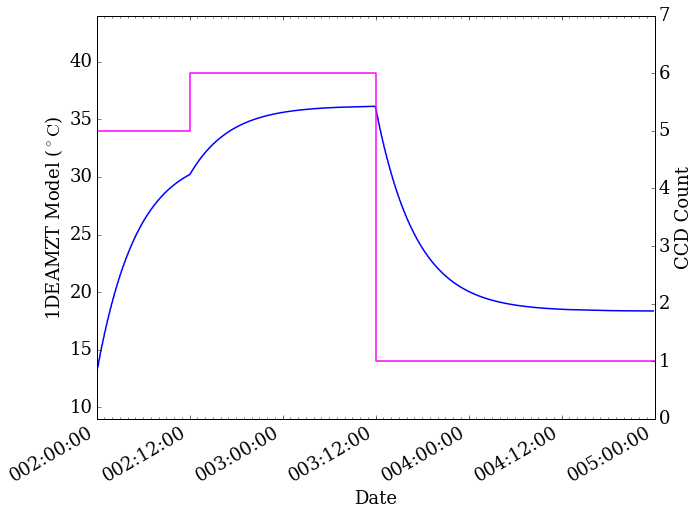

In [8]:
dp = DatePlot(dea_model, [("model", "1deamzt")], field2=("states","ccd_count"))
dp.set_ylim2(0,7)

We can also dump the results of the model run to disk, both the states and the model components:

In [9]:
dea_model.write_model("model.dat")
dea_model.write_states("states.dat")

These files can be loaded in at a later date using `DataContainer.fetch_models_from_files()`.

## Running a Thermal Model from a `states.dat` file

One can also run a thermal model from a `states.dat` table file which would be outputted by the thermal model check scripts during a load review, using the `from_states_table()` method (it is still necessary to supply start and stop times and an initial temperature):

In [10]:
tstart = '2017:035:18:27:42.816'
tstop = '2017:051:05:33:26.816'
T_init = 34.71

In [11]:
dpa_model = ThermalModelRunner.from_states_table("dpa", tstart, tstop, "my_states.dat", T_init)

## Running Thermal Models Using Real-Life Data

If you want to use the commanded states database and the engineering archive as inputs for a model run, use the special class `ThermalModelFromData`, which will take MSIDs and states from a `DataContainer` instance and run a model using them:

In [ ]:
dc = DataContainer.fetch_from_database("2016:091:12:05:00.100", "2016:100:13:07:45.234", msid_keys=["1dpamzt"])
dpa_model = ThermalModelFromData(dc, "dpa")

This can be used to plot MSID and model data simultaneously:

In [ ]:
dp = DatePlot(dpa_model, [("msids", "1dpamzt"), ("model", "1dpamzt")])

## Simulating CTI Runs

A special case of running a thermal model in ACISpy is simulating a CTI run, which may be performed after a safing action. The `SimulateCTIRun` class simplifies the call to `ThermalModelRunner` by assuming that the state is constant over time. The goal is to predict at what time after the start of the run the temperature will hit a particular limit. 

To run this model, we only need specify a few parameters (some of which are optional and have default values):

In [ ]:
pitch = 150. # in degrees
T_init = 7.5 # in degrees C
ccd_count = 6 # number of CCDs, optional, default 6
simpos = -99616.0 # SIM-Z position, optional, default -99616.0
off_nominal_roll = 0.0 # in degrees, optional, default 0.0
dh_heater = 0 # is the detector housing heater on (1) or off (0)? default 0

We pick a model to run, a start time, and feed them and the above parameters into `SimulateCTIRun`:

In [ ]:
dea_cti_run = SimulateCTIRun("dea", "2015:002:00:00:00", T_init, pitch, ccd_count=ccd_count, 
                             simpos=simpos, off_nominal_roll=off_nominal_roll, dh_heater=dh_heater)

The run also reports the time when the limit was reached. We can plot the model using the `plot_model()` method, 
which shows the limit value as a dashed green line and the time at which the limit was reached as a dashed red line:

In [ ]:
dp = dea_cti_run.plot_model()

You can also do a quick-check of the asymptotic temperature:

In [ ]:
dea_cti_run.asymptotic_temperature

Note that for some combinations of parameters the limit may never be reached. For example, let's knock the CCD count down to 4:

In [ ]:
dea_cti_run = SimulateCTIRun("dea", "2015:002:00:00:00", T_init, pitch, ccd_count=4, 
                             simpos=simpos, off_nominal_roll=off_nominal_roll, dh_heater=dh_heater)

In [ ]:
dp = dea_cti_run.plot_model()